In [60]:
# Model design
import agentpy as ap
import random
import numpy as np

# Needed for running models
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
import IPython
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import label, binary_dilation
from scipy.stats import linregress
import powerlaw

# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:

'''
Modified from Foramitti, J. (2021). Forest fire model example (AgentPy). Retrieved from https://agentpy.readthedocs.io/en/latest/agentpy_forest_fire.html


Rules of the system:
1. A burning tree becomes an empty site
2. A green tree becomes burning if at least one of its neighbours is burning
3. At an empty site, a tree grows with the probability p
4. A tree without a burning neighbour becomes a burning tree at any time step with the probability f ('lightning')
'''

"\nRules of the system:\n1. A burning tree becomes an empty site\n2. A green tree becomes burning if at least one of its neighbours is burning\n3. At an empty site, a tree grows with the probability p\n4. A tree without a burning neighbour becomes a burning tree at any time step with the probability f ('lightning')\n"

In [48]:

class ForestModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        n_trees = int(self.p['Tree density'] * (self.p.size**2))
        trees = self.agents = ap.AgentList(self, n_trees)

        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.forest.add_agents(trees, random=True, empty=True)

        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Burning, 2: Empty
        self.agents.condition = 0        
        # Amount of lightning
        self.f = self.p['probability of lightning']

        # Assign value to p
        self.growth = self.p["probability of regrowth"]

        self.tree_counts = []  # Initialize list to store number of trees
        #we could also maybe delete these:
        self.cluster_counts = []
        self.cluster_size = []
        #until here
        #added
        self.cluster_size_notime = []
        self.cluster_counts_notime = []

    #maybe we can actually delete this
    def count_fire_clusters(self):
        # Build 2D array of conditions
        grid_state = np.full(self.forest.shape, 2,dtype=np.int8)
        for agent in self.agents:
            x, y = self.forest.positions[agent]
            grid_state[x, y] = int(agent.condition)

        # Mask the target state (1 = burning, 0 = tree, etc.)
        mask = (grid_state == 1)

        # Identify clusters of healthy trees (0)
        structure = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=int)  # 4-connected
        labeled, num = label(mask, structure=structure)

        if num == 0:
            return 0, []
        counts = np.bincount(labeled.ravel())[1:]
        return num, counts
    #added
    def count_connected_to_healthy(self):
        # Build 2D array of conditions
        grid_state = np.full(self.forest.shape, 2,dtype=np.int8)
        for agent in self.agents:
            x, y = self.forest.positions[agent]
            grid_state[x, y] = int(agent.condition)

        # Mask the target states (tree, ignited)
        healthy_mask = (grid_state == 0)
        fire_mask = (grid_state == 3)

        # Identify clusters of healthy trees (0)
        structure = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=bool)  # 4-connected
        labeled, num = label(healthy_mask, structure=structure)

        if num == 0:
            return 0, []
        # Dilate fire_mask to mark all its 4-neighbors
        dilated_fire = binary_dilation(fire_mask, structure=structure)
        touching_labels = np.unique(labeled[dilated_fire & healthy_mask])
        touching_labels = touching_labels[touching_labels > 0]  # remove background 0

        if len(touching_labels) == 0:
            return 0, []
        counts = np.bincount(labeled.ravel())[1:]
        connected_counts = counts[np.array(touching_labels) - 1]
        total_connected_trees = int(np.sum(connected_counts))
        return total_connected_trees, connected_counts.tolist()



    def step(self):
        # Lightning: mark newly struck trees as 3 for measurements
        for t in self.agents.select(self.agents.condition == 0):
            if random.random() < self.f:
                t.condition = 3

        # Save cluster sizes
        size_every_cluster_without_time, size_clusters_without_time = self.count_connected_to_healthy()
        self.cluster_size_notime.append(size_every_cluster_without_time)
        self.cluster_counts_notime.append(size_clusters_without_time)

        # Turn 3 → 1 so they act as burning trees
        for t in self.agents.select(self.agents.condition == 3):
            t.condition = 1

        # Fire spreads
        for t in self.agents.select(self.agents.condition == 1):
            for n in self.forest.neighbors(t):
                if n.condition == 0:
                    n.condition = 1
            t.condition = 2  # this burning tree is now burned out

        # Regrow trees
        for t in self.agents.select(self.agents.condition == 2):
            if random.random() < self.growth:
                t.condition = 0

        # Record tree counts
        self.tree_counts.append(len(self.agents.select(self.agents.condition == 0)))


    def end(self):

        # Document a measure at the end of the simulation
        burned_trees = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of burned trees',
                    burned_trees / len(self.agents))

In [70]:
# Define parameters

parameters_animation = {
    'Tree density': 1, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 200,
    'probability of lightning': 0.001,
    'probability of regrowth': 0.01
}

parameters = {
    'Tree density': 1, # Percentage of grid covered by trees
    'size': 200, # Height and length of the grid
    'steps': 2000,
    'probability of lightning': 0.0001,
    'p_over_f': 100 # assign a ratio to ensure that f << p
}

In [71]:
# Create single-run animation with custom colors
def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', 3: '#ffb347',None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents.select(model.agents.condition == 0))}")
def animation_plot_values(model):
    time_steps = []
    attr_grid = model.forest.attr_grid('condition')
    model.tree_counts.append(len(model.agents.select(model.agents.condition == 0)))
    return time_steps, model.tree_counts


fig, ax = plt.subplots()
model = ForestModel(parameters_animation)
animation = ap.animate(model, fig, ax, animation_plot)
animation.save('forest_fire_animation.gif', writer='pillow', fps=15)
IPython.display.HTML(animation.to_jshtml(fps=15))


In [52]:
list_lightning = [1e-3, 1e-5, 1e-6]
list_p_over_f  = [10, 1000, 10000]
records = []   # this will hold all rows

for f in list_lightning:
    for growth in list_regrowth:
        params = parameters.copy()
        params['probability of lightning'] = f
        params['probability of regrowth'] = growth

        model = ForestModel(params)
        model.run()

        # Tree counts
        for t, trees in enumerate(model.tree_counts):
            records.append({"type": "tree_count",
                            "time": t,
                            "tree_count": trees,
                            "fire_size": np.nan,
                            "f": f,
                            "growth": growth})

        # Fire sizes
        all_clusters = []
        for lst in model.cluster_counts_notime:
            if isinstance(lst, (list, np.ndarray)) and len(lst) > 0:
                all_clusters.extend(lst)
        for s in all_clusters:
            records.append({"type": "fire",
                            "time": np.nan,
                            "tree_count": np.nan,
                            "fire_size": s,
                            "f": f,
                            "growth": growth})

# Convert to DataFrame and save
df = pd.DataFrame.from_records(records)
df.to_csv("forest_fire_results.csv", index=False)
print("data saved to forest_fire_results.csv")

Completed: 2000 steps
Run time: 0:04:17.820637
Simulation finished
Completed: 2000 steps
Run time: 0:04:28.582409
Simulation finished
Completed: 2000 steps
Run time: 0:03:02.368725
Simulation finished
Completed: 2000 steps
Run time: 0:01:39.854220
Simulation finished
Completed: 2000 steps
Run time: 0:02:14.400003
Simulation finished
Completed: 2000 steps
Run time: 0:04:25.972563
Simulation finished
Completed: 2000 steps
Run time: 0:05:13.811764
Simulation finished
Completed: 2000 steps
Run time: 0:04:29.325250
Simulation finished
Completed: 2000 steps
Run time: 0:04:21.352493
Simulation finished
data saved to forest_fire_results.csv


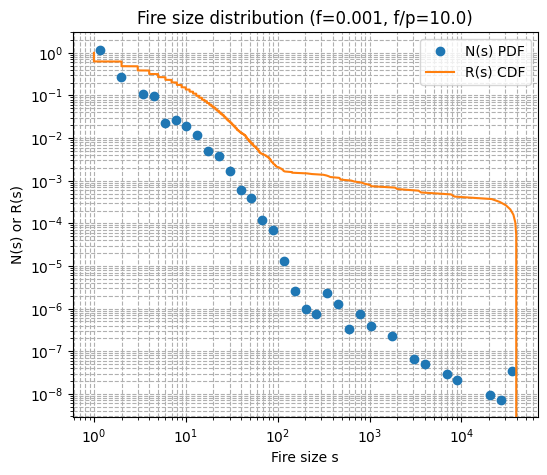

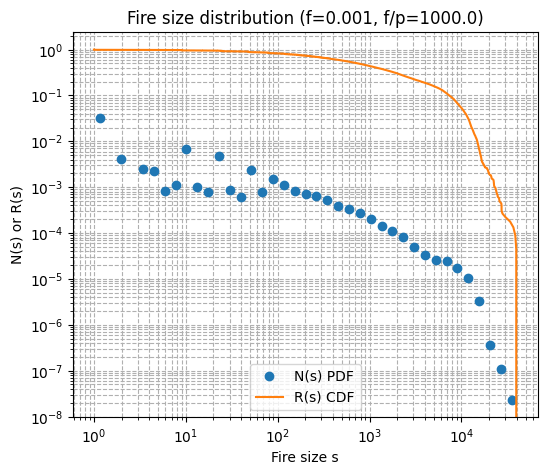

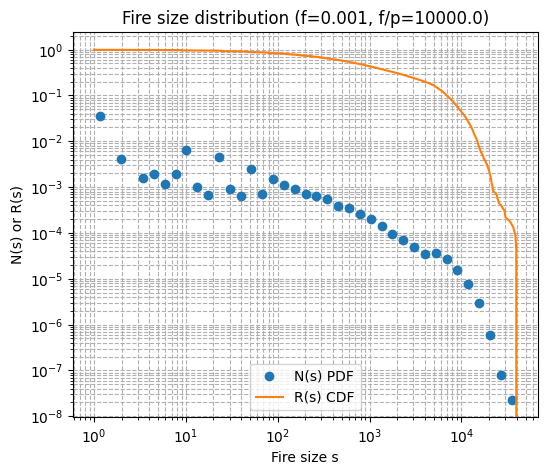

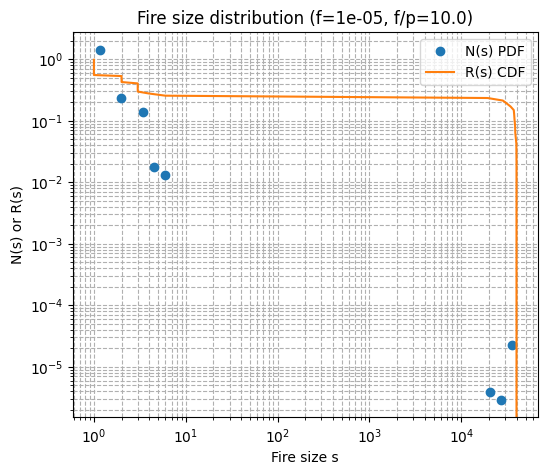

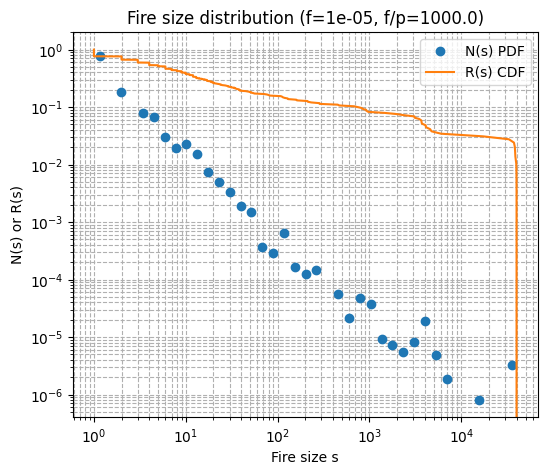

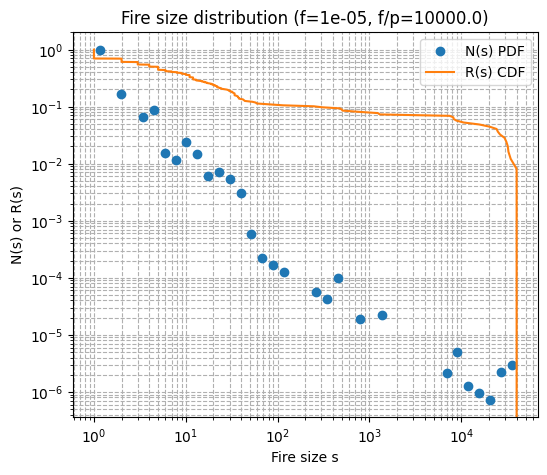

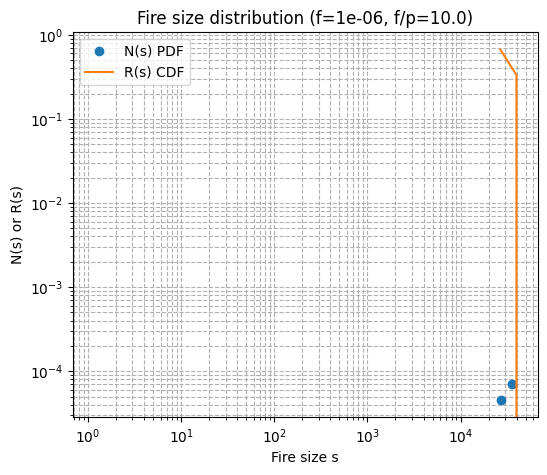

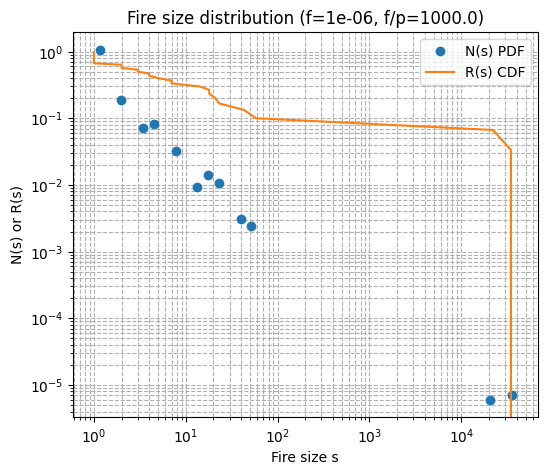

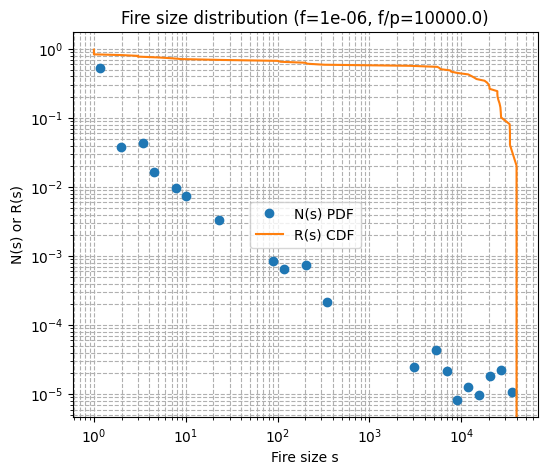

In [62]:
df = pd.read_csv("forest_fire_results.csv")
df_fires = df[df["type"]=="fire"]
param_sets = df[['f','growth']].drop_duplicates()

for _, row in param_sets.iterrows():
    f = row['f']; p_ratio = row['growth']
    fires = df_fires[(df_fires['f']==f) & (df_fires['growth']==growth)]['fire_size'].dropna()
    if fires.empty: 
        continue

    sizes = np.sort(fires.values)
    
    # PDF N(s)
    bins = np.logspace(np.log10(1), np.log10(sizes.max()+1), 40)
    hist, edges = np.histogram(sizes, bins=bins, density=True)
    centers = 0.5*(edges[:-1] + edges[1:])

    #  CDF R(s)
    cdf = 1.0 - np.arange(1, len(sizes)+1)/len(sizes)

    plt.figure(figsize=(6,5))
    plt.loglog(centers, hist, 'o', label='N(s) PDF')
    plt.loglog(sizes, cdf, '-', label='R(s) CDF')
    plt.title(f"Fire size distribution (f={f}, f/p={p_ratio})")
    plt.xlabel("Fire size s")
    plt.ylabel("N(s) or R(s)")
    plt.legend()
    plt.grid(True, which='both', ls='--')

In [77]:
L = 200  
df_trees = df[df['type'] == 'tree_count'].copy()

# Compute density
df_trees['density'] = df_trees['tree_count'] / (L**2)

# Sort to ensure correct time order within each parameter set
df_trees = df_trees.sort_values(['f', 'p_over_f', 'time'])



# Merge with average density for reference
avg_density = (
    df_trees.groupby(['f', 'p_over_f'])['density']
    .mean()
    .reset_index(name='avg_density')
)

# Print results
print(avg_density.sort_values(['f', 'p_over_f']))

          f  p_over_f  avg_density
0  0.000001        10     0.066484
1  0.000001      1000     0.296565
2  0.000001     10000     0.523008
3  0.000010        10     0.111478
4  0.000010      1000     0.339439
5  0.000010     10000     0.281599
6  0.001000        10     0.228489
7  0.001000      1000     0.778124
8  0.001000     10000     0.779555


In [163]:
# #nr of trees per timestep
# parameters['steps'] = 2000
# fig, axs = plt.subplots(4, 4, figsize=(16, 16))
# list_lightning = [0.00001, 0.0001, 0.001, 0.01]
# list_p_over_f = [100, 1000, 10000, 100000]
# for i, f in enumerate(list_lightning):
#     for j, p in enumerate(list_p_over_f):
#         ax = axs[i, j]  # select subplot
#         parameters['probability of lightning'] = f
#         parameters['p_over_f'] = p
#         model = ForestModel(parameters)
#         model.run()
    
#         ax.plot(model.tree_counts)
#         ax.set_title(f"Lightning={f}, p_over_f_ratio={p}", fontsize=10)
#         ax.set_xlabel("Time Step")
#         ax.set_ylabel("Trees")
#         ax.grid(True)

# plt.tight_layout()
# plt.show()


In [ ]:
# #shows the size of forest fires ones they are ignited
# #only looks at connected trees when a tree is ignited by lightning
# #ignores the trees that could grow in timesteps after ignition to also be burned down
# #ignores that it takes multiple timesteps to grow to this size of forest fire
# #gives sort of approximation of the forest fire from a starting point only, ignores time steps
# #and the influence of time on the model.
# parameters['steps'] = 2000
# fig, axs = plt.subplots(4, 4, figsize=(16, 16))
# list_lightning = [0.00001, 0.0001, 0.001, 0.01]
# list_p_over_f = [100, 1000, 10000, 100000]
# for i, f in enumerate(list_lightning):
#     for j, p in enumerate(list_p_over_f):
#         ax = axs[i, j]  # select subplot
#         parameters['probability of lightning'] = f
#         parameters['p_over_f'] = p
#         model = ForestModel(parameters)
#         model.run()
    
#         ax.plot(model.cluster_size_notime, color='darkred', lw=1.5)
#         ax.set_title(f"Lightning={f}, p_over_f_ratio={p}", fontsize=10)
#         ax.set_xlabel('Time step')
#         ax.set_ylabel('size of fire clusters')
#         ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


In [ ]:
# #shows the power law distribution
# #how often each size of forest fire per tree cluster occurs in the model
# #only looks at connected trees when a tree is ignited by lightning
# #ignores the trees that could grow in timesteps after ignition to also be burned down
# #comes most close but still incomplete
# parameters['steps'] = 2000
# fig, axs = plt.subplots(4, 4, figsize=(16, 16))
# list_lightning = [0.00001, 0.0001, 0.001, 0.01]
# list_p_over_f = [100, 1000, 10000, 100000]
# for i, f in enumerate(list_lightning):
#     for j, p in enumerate(list_p_over_f):

#         ax = axs[i, j]  # select subplot
#         parameters['probability of lightning'] = f
#         parameters['p_over_f'] = p
#         model = ForestModel(parameters)
#         model.run()

#         all_sizes = np.concatenate(model.cluster_counts_notime)  # flatten nested arrays

#         values, counts = np.unique(all_sizes, return_counts=True)
#         ax.fill_between(values, counts, color='orange', alpha=0.4)
#         ax.plot(values, counts, color='darkorange', lw=1.5)
#         ax.set_title(f"distr fire_sizes, f={f}, p_over_f_ratio={p}", fontsize=10)
#         ax.set_xlabel('Cluster size (# burning trees)')
#         ax.set_ylabel('Frequency')
#         ax.set_yscale('log')
#         ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


In [ ]:
# #(we could maybe just delete this)
# #shows the nr of fire clusters per time step, but ignores the history of clusters
# #this means that fires in next step are seen as 'new' cluster even when they were
# #ignited earlier
# #so incomplete image, but keeping track of history was too difficult
# parameters['steps'] = 2000
# fig, axs = plt.subplots(4, 4, figsize=(16, 16))
# list_lightning = [0.00001, 0.0001, 0.001, 0.01]
# list_p_over_f = [100, 1000, 10000, 100000]
# for i, f in enumerate(list_lightning):
#     for j, p in enumerate(list_p_over_f):
#         ax = axs[i, j]  # select subplot
#         parameters['probability of lightning'] = f
#         parameters['p_over_f'] = p
#         model = ForestModel(parameters)
#         model.run()
    
#         ax.plot(model.cluster_counts, color='darkred', lw=1.5)
#         ax.set_title(f"Lightning={f}, p_over_f_ratio={p}", fontsize=10)
#         ax.set_xlabel('Time step')
#         ax.set_ylabel('Number of fire clusters')
#         ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [ ]:
#(we could maybe just delete this)
#shows the distribution of fire clusters given the model that does not account for 
#the history of clusters
#this means that clusters of high sizes are impossible and not accounted for, and it means that
#the number of clusters are too high, and occur too often because multiple clusters per timestep
#are seen as different clusters, while they are not similar clusters. 
#so incomplete, but does account for time steps

# parameters['steps'] = 2000
# fig, axs = plt.subplots(4, 4, figsize=(16, 16))
# list_lightning = [0.00001, 0.0001, 0.001, 0.01]
# list_p_over_f = [100, 1000, 10000, 100000]
# for i, f in enumerate(list_lightning):
#     for j, p in enumerate(list_p_over_f):

#         ax = axs[i, j]  # select subplot
#         parameters['probability of lightning'] = f
#         parameters['p_over_f'] = p
#         model = ForestModel(parameters)
#         model.run()

#         all_sizes = np.concatenate(model.cluster_size)  # flatten nested arrays
#         # Sort sizes and get their frequencies
#         values, counts = np.unique(all_sizes, return_counts=True)
    
#         ax.fill_between(values, counts, color='orange', alpha=0.4)
#         ax.plot(values, counts, color='darkorange', lw=1.5)
#         ax.set_title(f"distr fire_sizes, f={f}, p_over_f_ratio={p}", fontsize=10)
#         ax.set_xlabel('Cluster size (# burning trees)')
#         ax.set_ylabel('Frequency')
#         ax.set_yscale('log')
#         ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()




In [ ]:
#some more plots of the nr of fire clusters per time step, but ignores the history of clusters
# #but with fixed f = 0.0001
# #we could probably also delete this
# import matplotlib.pyplot as plt
# parameters['steps'] = 2000
# parameters['probability of lightning'] = 0.0001
# list_p_over_f = [100, 1000, 10000, 100000]
# fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# for i,p in enumerate(list_p_over_f):
#     parameters['p_over_f'] = p
#     model = ForestModel(parameters)
#     model.run()
#     ax = axs[i]


#     ax.plot(model.cluster_counts)
#     ax.set_title(f"fire clusters over time,  p_over_f_ratio={p}", fontsize=10)
#     ax.set_xlabel("Time Step")
#     ax.set_ylabel("Number of fire clusters")
#     ax.grid(True)

# plt.tight_layout()
# plt.show()